<a href="https://www.kaggle.com/code/tompaulat/cnn-classifying-architectural-photography?scriptVersionId=108775182" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Is a CNN Able to Classify Fotos (Interior vs. Exterior) of Modern Architecure? 

## Imports

In [1]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
from sklearn.model_selection import train_test_split

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

from numpy.random import seed
seed(42)

# Loading in the Image Arrays (.npy) 

We will use the [dataset on Modern Architecture](https://www.kaggle.com/datasets/tompaulat/modern-architecture-100k-small-images).

In [2]:
appart_path = '../input/modern-architecture-100k-small-images/Dataset_128px_128px_Images/Appartments'
appart_files = [f for f in os.listdir(appart_path)]

df = pd.DataFrame()
df['Names']= appart_files
df['Img_array'] = list(np.load('../input/modern-architecture-100k-small-images/Dataset_128px_128px_Images/Image_Array_Appart.npy'))

See [Exploring Images of Modern Architecture](https://www.kaggle.com/code/tompaulat/exploring-images-of-modern-architecture) to get an introduction to the data. There we have determined that the images are labeled with whether the foto was taken from the outside or inside. Therefore we append this information to the dataset.

In [3]:
exterior_list = []
interior_list = []
for i, rows in df.iterrows():
    if 'Interior' in rows[0]:
        interior_list.append(1)
        exterior_list.append(0)
    elif 'Exterior' in rows[0]:
        interior_list.append(0)
        exterior_list.append(1)
    else: 
        interior_list.append(0)
        exterior_list.append(0)
        
df['Exterior'] = exterior_list
df['Interior'] = interior_list

Now we create a dataframe only containing img_array if either `Exterior==1` or `Interior==1`

In [4]:
df_binary = df.query('Exterior == 1 | Interior == 1')
print(f'There are {df_binary.shape[0]} images classified as either a Interior Photography ({sum(list(df_binary.Interior))}) or Exterior Photography ({sum(list(df_binary.Exterior))})')

There are 24640 images classified as either a Interior Photography (16121) or Exterior Photography (8519)


In [5]:
# clear df from RAM
import gc
del df
gc.collect()

45

# Downsampling Image Data 

Let first downsample the Interior Images to have a balanced dataset. This loses some data (other approaches will be studied in the future).

In [6]:
df_inter_down = df_binary.query('Interior==1').sample(sum(list(df_binary.Exterior)))
df_model = pd.concat([df_inter_down, df_binary.query('Exterior==1')])

In [7]:
print(f'After downsampling there are {df_model.shape[0]} images classified as either a Interior Photography ({sum(list(df_model.Interior))}) or Exterior Photography ({sum(list(df_model.Exterior))})')

After downsampling there are 17038 images classified as either a Interior Photography (8519) or Exterior Photography (8519)


In [8]:
# clear df_binary from RAM
del df_binary
gc.collect()

42

# Create Train and Test Sets

First lets choose a subset of 5000 images to construct the model. 

In [9]:
df_model_5000samples = df_model.sample(5000)

Now we can split the data first into the data and labels.

In [10]:
data = df_model_5000samples.Img_array.to_list()
labels = df_model_5000samples.Exterior.to_list()

For the prediction label we used whether the image was taken from outside (`Exterior=1`) or inside (`Exterior=0`)
Lets examine the two lists

In [11]:
len(data), len(labels) 

(5000, 5000)

In [12]:
data[:2], labels[:2]

([array([[[234, 190, 166],
          [235, 191, 167],
          [235, 191, 167],
          ...,
          [240, 213, 186],
          [240, 213, 186],
          [240, 213, 186]],
  
         [[235, 191, 167],
          [236, 192, 168],
          [236, 192, 168],
          ...,
          [241, 214, 187],
          [241, 214, 187],
          [240, 213, 186]],
  
         [[236, 192, 168],
          [236, 192, 168],
          [237, 193, 169],
          ...,
          [239, 215, 187],
          [239, 215, 187],
          [237, 213, 185]],
  
         ...,
  
         [[ 53,  80,  70],
          [ 50,  77,  67],
          [ 56,  83,  73],
          ...,
          [ 75,  61,  63],
          [ 94,  80,  82],
          [ 90,  76,  78]],
  
         [[ 53,  79,  66],
          [ 35,  61,  48],
          [ 37,  63,  50],
          ...,
          [ 55,  41,  45],
          [ 68,  54,  58],
          [ 59,  45,  49]],
  
         [[ 51,  75,  63],
          [ 47,  71,  59],
          [ 48,  72,  60

In [13]:
## Defining the train test split 
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

del data, labels
gc.collect()

105

In [14]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Defining the CNN

In [15]:
INPUT_SHAPE = (128, 128, 3)   #change to (SIZE, SIZE, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))  


2022-10-21 19:51:28.464951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 19:51:28.561284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 19:51:28.562143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 19:51:28.563351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',             #also try rmsprop
              metrics=['accuracy'])

print(model.summary())   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1

# Running the Model

In [17]:
history = model.fit(X_train, 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 20,      
                         validation_data=(X_test,y_test),
                         shuffle = False
                     )


model.save('Photography_Classifier_20epochs_5000images.h5')  


2022-10-21 19:51:31.360840: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 196608000 exceeds 10% of free system memory.
2022-10-21 19:51:31.632613: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 196608000 exceeds 10% of free system memory.
2022-10-21 19:51:31.807177: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-21 19:51:33.372955: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - ETA: 0s - loss: 38.2266 - accuracy: 0.6695

2022-10-21 19:51:40.243750: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 49152000 exceeds 10% of free system memory.
2022-10-21 19:51:40.315710: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 49152000 exceeds 10% of free system memory.


63/63 [==============================] - 9s 19ms/step - loss: 38.2266 - accuracy: 0.6695 - val_loss: 0.4889 - val_accuracy: 0.8150
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 1.3180 - accuracy: 0.7225 - val_loss: 0.5244 - val_accuracy: 0.7270
Epoch 3/20
63/63 [==============================] - 1s 13ms/step - loss: 0.8082 - accuracy: 0.6555 - val_loss: 0.4913 - val_accuracy: 0.7600
Epoch 4/20
63/63 [==============================] - 1s 13ms/step - loss: 0.6660 - accuracy: 0.6957 - val_loss: 0.5149 - val_accuracy: 0.7990
Epoch 5/20
63/63 [==============================] - 1s 13ms/step - loss: 0.5726 - accuracy: 0.7555 - val_loss: 0.3739 - val_accuracy: 0.8560
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 0.5180 - accuracy: 0.7853 - val_loss: 0.4470 - val_accuracy: 0.7950
Epoch 7/20
63/63 [==============================] - 1s 13ms/step - loss: 0.5715 - accuracy: 0.7590 - val_loss: 0.4387 - val_accuracy: 0.8470
Epoch 8/20
63/63 [=====

# Visualizing the Model Accuracy

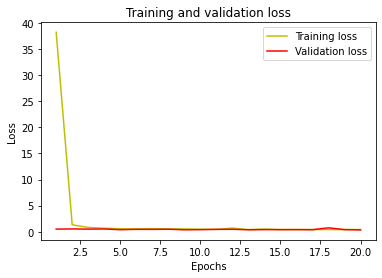

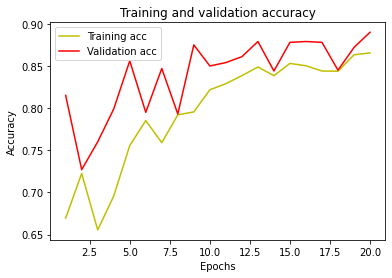

In [18]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Example Images: Prediction vs True Labels

As a reminder as label we used whether the foto was taken from outside (label=1) or inside (label=0) 

The prediction for this image is:  0.031392418
The actual label for this image is:  0


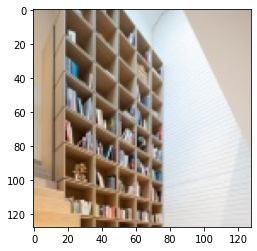

In [19]:
n= 4 #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img[...,::-1])
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img).squeeze())
print("The actual label for this image is: ", y_test[n])

The prediction for this image is:  0.99378973
The actual label for this image is:  1


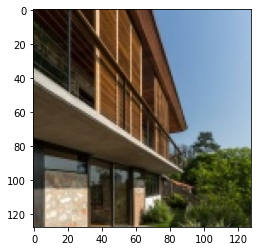

In [20]:
n= 5 #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img[...,::-1])
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img).squeeze())
print("The actual label for this image is: ", y_test[n])

The prediction for this image is:  0.9999051
The actual label for this image is:  1


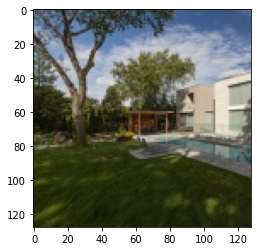

In [21]:
n=15 #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img[...,::-1])
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img).squeeze())
print("The actual label for this image is: ", y_test[n])

The prediction for this image is:  0.14804892
The actual label for this image is:  0


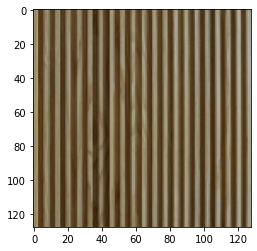

In [22]:
n= 122 #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img[...,::-1])
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img).squeeze())
print("The actual label for this image is: ", y_test[n])

The prediction for this image is:  0.011690712
The actual label for this image is:  0


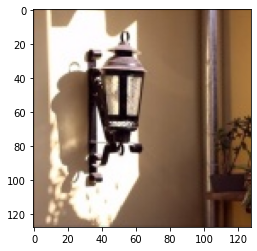

In [23]:
n= 289 #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img[...,::-1])
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img).squeeze())
print("The actual label for this image is: ", y_test[n])

**It seems that the algorith is not able to predict accurately when there are not enough distinct features.**'

## Confusion Matrix

16/32 [==============>...............] - ETA: 0s - loss: 0.3158 - accuracy: 0.9023

2022-10-21 19:52:16.187962: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 49152000 exceeds 10% of free system memory.


32/32 [==============================] - 0s 4ms/step - loss: 0.3371 - accuracy: 0.8900
The accuracy of the model =  88.99999856948853 %


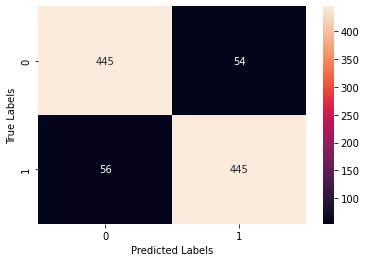

In [24]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

_, acc = model.evaluate(X_test, y_test)
print("The accuracy of the model = ", (acc * 100.0), "%")
pred = model.predict(X_test)
ypred = (pred > 0.5)
cm = confusion_matrix(y_test, ypred)
f = sns.heatmap(cm, annot=True, fmt='d')
f.set(xlabel='Predicted Labels', ylabel='True Labels')

plt.show()

# Visualizing the CNN layers (feature maps)

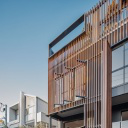

In [25]:
# Lets read in some image
img = load_img('../input/modern-architecture-100k-small-images/Dataset_128px_128px_Images/Appartments/08 Albatross Avenue House Studio Workshop Facade .jpg')
img

## How is this image passed through the feature maps? 

# *Feature Map of Layer 1*

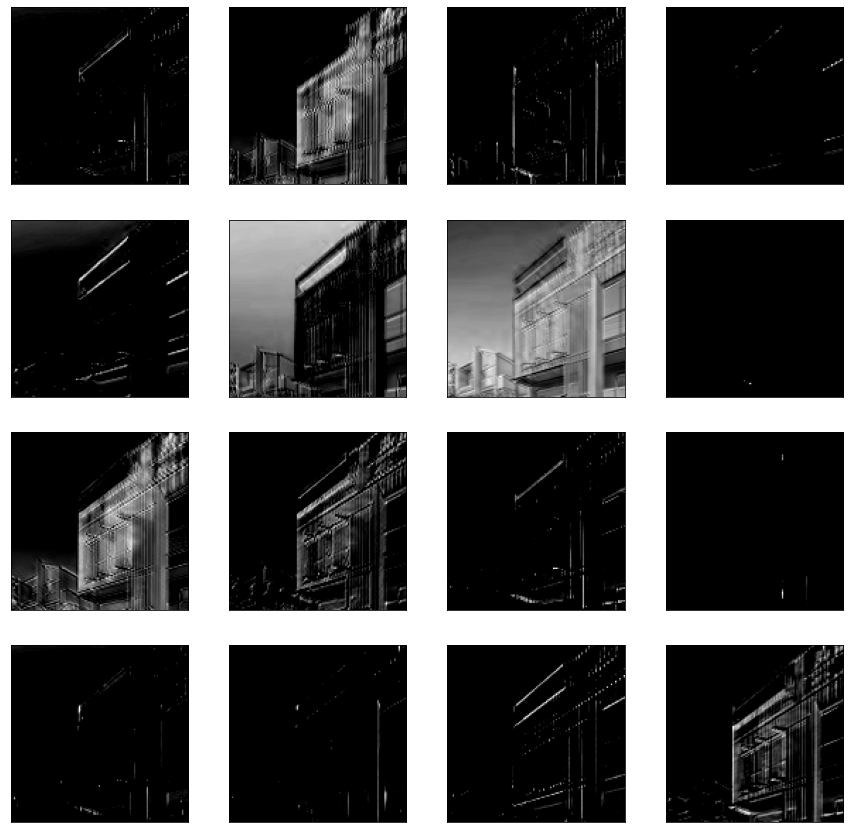

# *Feature Map of Layer 3*

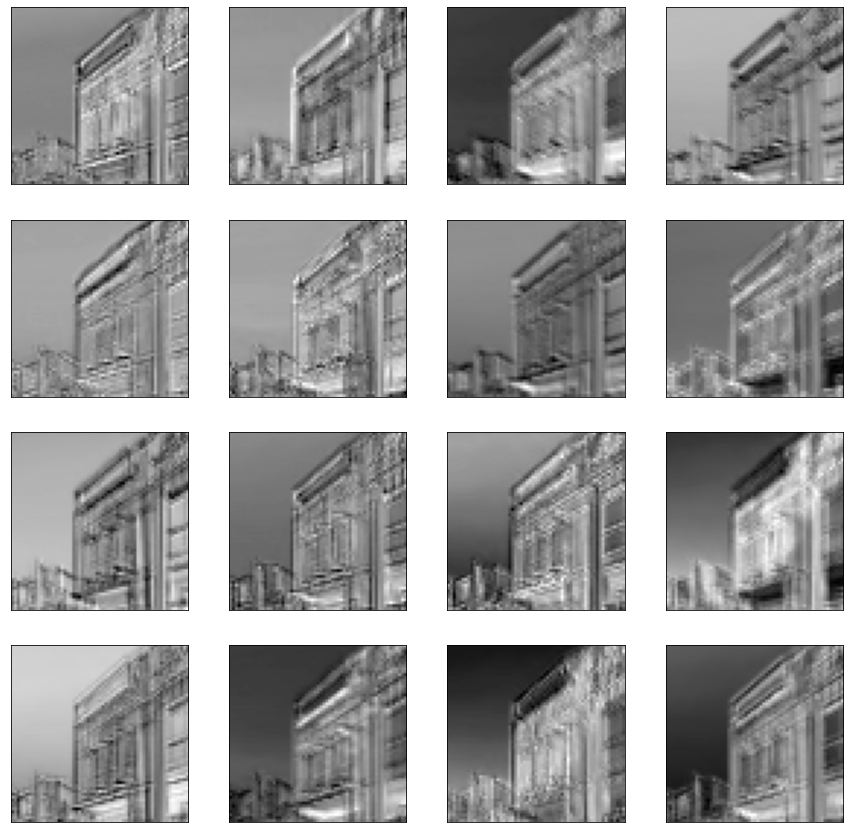

# *Feature Map of Layer 6*

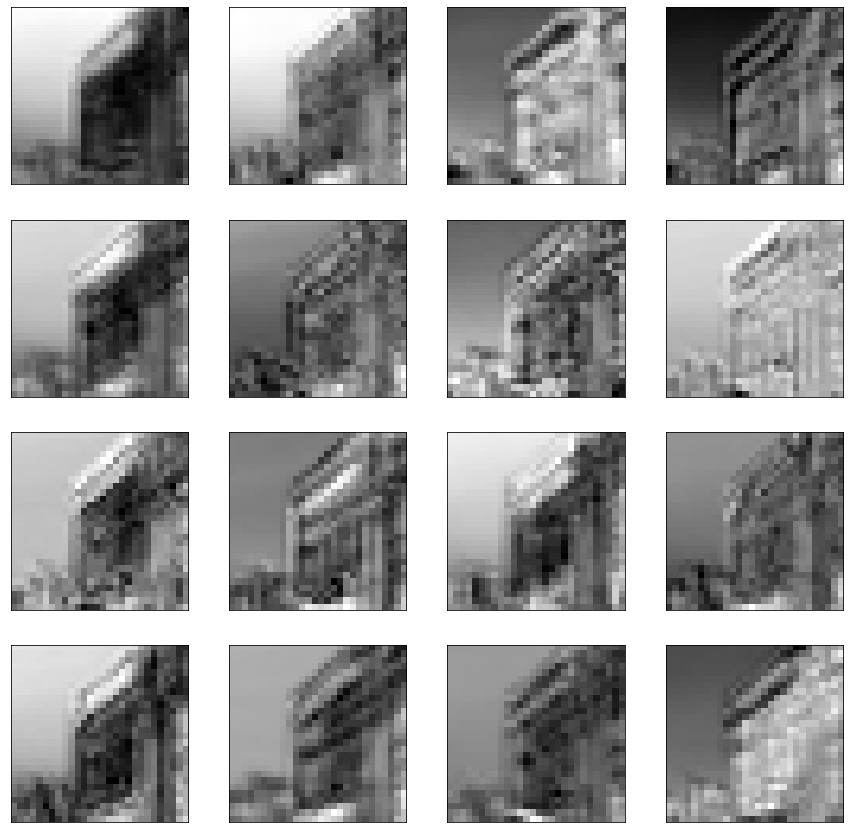

In [26]:
for i in [1, 3, 6]:
    model_layer = Model(inputs=model.inputs, outputs=model.layers[i].output)
    img = load_img('../input/modern-architecture-100k-small-images/Dataset_128px_128px_Images/Appartments/08 Albatross Avenue House Studio Workshop Facade .jpg')
    # convert the image to an array
    img = img_to_array(img)
    # expand dimensions so that it represents a single 'sample'
    img = np.expand_dims(img, axis=0)
    # prepare the image (e.g. scale pixel values for the vgg)

    # get feature map 
    feature_maps = model_layer.predict(img)
    # plot the output from each block
    square = 4
    ix = 1
    plt.figure(figsize=(15,15))
    printmd(f"# *Feature Map of Layer {i}*")
    for _ in range(square):
        for _ in range(square):
        # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    plt.show()